<a href="https://colab.research.google.com/github/chetxn04/Discrete_KV_Bottleneck/blob/main/NUS_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cpu
Loading MNIST dataset...
Training with classes: 0 and 1
[KV Bottleneck] Step [100/1000], Loss: 8.7827
[KV Bottleneck] Step [200/1000], Loss: 0.0542
[KV Bottleneck] Step [300/1000], Loss: 0.0495
[KV Bottleneck] Step [400/1000], Loss: 0.0487
[KV Bottleneck] Step [500/1000], Loss: 0.0484
[KV Bottleneck] Step [600/1000], Loss: 0.0485
[KV Bottleneck] Step [700/1000], Loss: 0.0487
[KV Bottleneck] Step [800/1000], Loss: 0.0482
[KV Bottleneck] Step [900/1000], Loss: 0.0490
[KV Bottleneck] Step [1000/1000], Loss: 0.0480
[MLP] Step [100/1000], Loss: 1.1683
[MLP] Step [200/1000], Loss: 0.0022
[MLP] Step [300/1000], Loss: 0.0001
[MLP] Step [400/1000], Loss: 0.0000
[MLP] Step [500/1000], Loss: 0.0000
[MLP] Step [600/1000], Loss: 0.0851
[MLP] Step [700/1000], Loss: 0.0000
[MLP] Step [800/1000], Loss: 0.0000
[MLP] Step [900/1000], Loss: 0.0000
[MLP] Step [1000/1000], Loss: 0.0000
Training with classes: 2 and 3
[KV Bottleneck] Step [100/1000], Loss: 0.0478
[KV Bottleneck] Step [200/1000], 

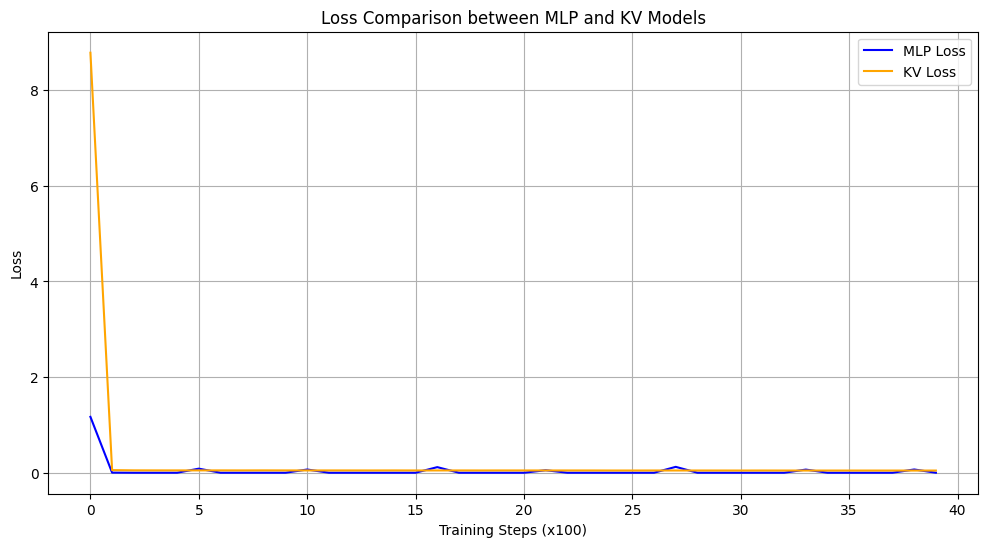

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# (tried training the model on gpu , was done successfully , but later faced issues due to tensors being on both cpu and cuda )
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def set_seed(seed=42): # (to ensure that this code has some degree of reproducibility , got this idea from GPT)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


print("Loading MNIST dataset...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
])

mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# creating this non staitonary dataset to ensure training in the manner described in the paper
class NonStationaryMNIST:
    def __init__(self, dataset, num_classes=8, examples_per_class=6000, steps_per_class=1000):
        self.dataset = dataset
        self.num_classes = num_classes
        self.examples_per_class = examples_per_class
        self.steps_per_class = steps_per_class
        self.current_step = 0
        self.pair_index = 0

        # Creating indices for all 6000 images of each class
        self.class_indices = {i: [] for i in range(num_classes)}
        for idx, (img, label) in enumerate(dataset):
            if label < num_classes and len(self.class_indices[label]) < examples_per_class:
                self.class_indices[label].append(idx)

    def get_pair_indices(self):
        class_a = (self.pair_index * 2) % self.num_classes
        class_b = (self.pair_index * 2 + 1) % self.num_classes
        indices_a = random.sample(self.class_indices[class_a], self.examples_per_class)
        indices_b = random.sample(self.class_indices[class_b], self.examples_per_class)
        return indices_a + indices_b

    def __iter__(self):
        while True:
            if self.current_step >= self.steps_per_class:
                self.current_step = 0
                self.pair_index = (self.pair_index + 1) % (self.num_classes // 2)

            indices = self.get_pair_indices()
            subset = Subset(self.dataset, indices)

            self.current_step += 1
            yield subset

# MLP model , working as competitor
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=32, num_classes=8):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# The key-value bottleneck model
class DiscreteKeyValueBottleneck(nn.Module):
    def __init__(self, num_keys=2000, key_dim=32, value_dim=8):  # this shows just one codebook , with 2000 keys and each key of dimension 32 and value of dimesnion 8
        super(DiscreteKeyValueBottleneck, self).__init__()
        self.num_keys = num_keys
        self.keys = nn.Parameter(torch.randn(num_keys, key_dim), requires_grad=False)  # Keys are frozen
        self.values = nn.Parameter(torch.randn(num_keys, value_dim))  # Values are learnable

    def forward(self, features):
        distances = torch.cdist(features.unsqueeze(1), self.keys.unsqueeze(0))
        _, indices = torch.min(distances, dim=2)  # Finding the closest key for each feature
        selected_values = self.values[indices.squeeze(1)]
        return selected_values

class KeyValueBottleneckModel(nn.Module):
    def __init__(self, bottleneck, input_dim=784, reduced_dim=32, output_dim=8):
        super(KeyValueBottleneckModel, self).__init__()
        self.feature_reduction = nn.Linear(input_dim, reduced_dim)  # Reduce from 784 to 32 dimensions
        self.bottleneck = bottleneck
        self.fc = nn.Linear(bottleneck.values.shape[1], output_dim)  # FC layer input size should match value_dim

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flattening the input (28x28 to 784)
        x = self.feature_reduction(x)
        x = self.bottleneck(x)  # forward pass through the Key-Value bottleneck
        x = self.fc(x)  # forward pass through the linear layer for classification
        return x

# Initialization
mlp_model = SimpleMLP(input_dim=28*28, hidden_dim=32, num_classes=8).to(device)
bottleneck = DiscreteKeyValueBottleneck(num_keys=2000, key_dim=32, value_dim=8).to(device)  # Key dimension set to 32
kv_model = KeyValueBottleneckModel(bottleneck).to(device)

criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
kv_optimizer = optim.Adam(kv_model.parameters(), lr=0.0025)

# Key initialization function
def initialize_keys_data_aware(bottleneck, dataset, num_keys=2000, num_classes=8):
    # to ensure a well distributed key intialziation , I ensured that we intialize keys using features from all classes equally
    # Credit to GPT for giving this idea after I tried K means and random intialziation both which gave sub par results
    keys_per_class = num_keys // num_classes

    # Collect features for each class
    class_features = {i: [] for i in range(num_classes)}
    for batch in dataset:
        if isinstance(batch, (list, tuple)):
            images, labels = batch
        else:
            images, labels = batch[0], batch[1]

        if isinstance(labels, int):
            images, labels = images.unsqueeze(0), torch.tensor([labels])

        for image, label in zip(images, labels):
            if label.item() < num_classes:
                image = image.view(-1).to(device)
                class_features[label.item()].append(image)

    # Sample representative points for each class
    selected_keys = []
    for class_label in range(num_classes):
        class_data = torch.stack(class_features[class_label])
        indices = torch.randperm(class_data.size(0))[:keys_per_class]
        selected_keys.append(class_data[indices])

    selected_keys = torch.cat(selected_keys, dim=0)

    # Reducing the dimension of the selected keys to match the key_dim using the feature reduction layer
    reduced_keys = kv_model.feature_reduction(selected_keys)

    # Initialize bottleneck keyz
    bottleneck.keys.data.copy_(reduced_keys)

initialize_keys_data_aware(bottleneck, mnist_dataset, num_keys=2000) #data-aware initialization with balanced class coverage

# Training loop with logging
mlp_losses = []
kv_losses = []

def train_model_with_logging(model, optimizer, data_iterator, steps, model_name="Model", loss_list=None):
    model.train()
    running_loss = 0.0
    for step in range(steps):
        data_subset = next(data_iterator)
        data_loader = DataLoader(data_subset, batch_size=32, shuffle=True)

        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if (step + 1) % 100 == 0:
            avg_loss = running_loss / 100
            print(f"[{model_name}] Step [{step + 1}/{steps}], Loss: {avg_loss:.4f}")
            if loss_list is not None:
                loss_list.append(avg_loss)  # USed for plotting and analysis
            running_loss = 0.0

# Train both models and log their losses
steps_per_class = 1000
num_classes = 8

for class_pair in range(0, num_classes, 2):
    print(f"Training with classes: {class_pair} and {class_pair + 1}")
    data_iter = NonStationaryMNIST(mnist_dataset, num_classes=num_classes, examples_per_class=1000, steps_per_class=steps_per_class)
    train_model_with_logging(kv_model, kv_optimizer, iter(data_iter), steps_per_class, model_name="KV Bottleneck", loss_list=kv_losses)
    train_model_with_logging(mlp_model, mlp_optimizer, iter(data_iter), steps_per_class, model_name="MLP", loss_list=mlp_losses)

plt.figure(figsize=(12, 6))
plt.plot(mlp_losses, label='MLP Loss', color='blue')
plt.plot(kv_losses, label='KV Loss', color='orange')
plt.title('Loss Comparison between MLP and KV Models')
plt.xlabel('Training Steps (x100)')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


MLP Validation Loss: 64.7455
KV Validation Loss: 10.0810


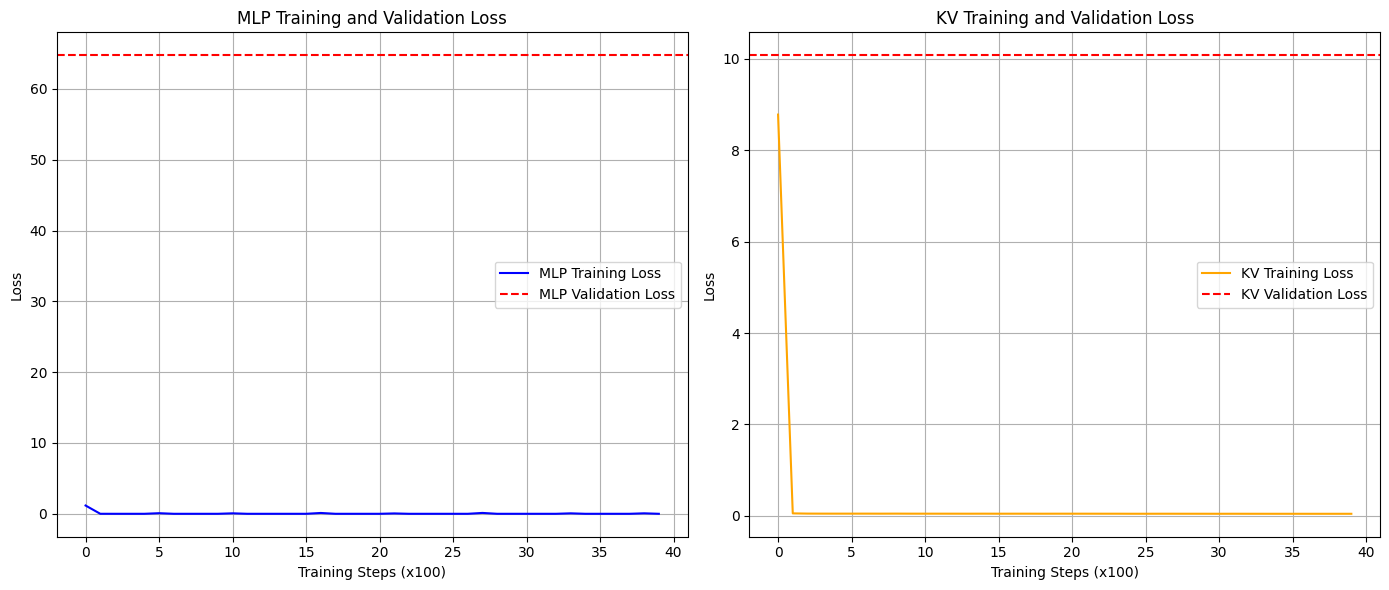

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This part of the code covers calcualting valdiaiton loss on teh MNIST test dataset.
def calculate_validation_loss_cpu(model, criterion, validation_loader):
    model.eval()
    validation_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item() * images.size(0)  # Accumulate total loss
            total_samples += images.size(0)

    avg_validation_loss = validation_loss / total_samples
    return avg_validation_loss

def create_filtered_validation_loader(dataset, valid_classes, batch_size=32):
    filtered_indices = [idx for idx, (_, label) in enumerate(dataset) if label in valid_classes]
    filtered_subset = Subset(dataset, filtered_indices)
    return DataLoader(filtered_subset, batch_size=batch_size, shuffle=False)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
valid_classes = list(range(8))  # Classes [0, 1, ..., 7]
validation_loader = create_filtered_validation_loader(mnist_test_dataset, valid_classes)

criterion = nn.CrossEntropyLoss()

mlp_validation_loss = calculate_validation_loss_cpu(mlp_model, criterion, validation_loader)
kv_validation_loss = calculate_validation_loss_cpu(kv_model, criterion, validation_loader)

print(f"MLP Validation Loss: {mlp_validation_loss:.4f}")
print(f"KV Validation Loss: {kv_validation_loss:.4f}")

# Plot training and validation loss curves for both models
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(mlp_losses, label='MLP Training Loss', color='blue')
plt.axhline(y=mlp_validation_loss, color='red', linestyle='--', label='MLP Validation Loss')
plt.title('MLP Training and Validation Loss')
plt.xlabel('Training Steps (x100)')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(kv_losses, label='KV Training Loss', color='orange')
plt.axhline(y=kv_validation_loss, color='red', linestyle='--', label='KV Validation Loss')
plt.title('KV Training and Validation Loss')
plt.xlabel('Training Steps (x100)')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

